In [1]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import einops

import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sg

from envelope_detector import SincLayer2d, SincHilbertLayer2d, WaveletLayer2d, ComplexWaveletLayer2d

C:\ProgramData\Anaconda3\envs\spopt\lib\site-packages\torchaudio\_internal\module_utils.py:99: UserWarning: Failed to import soundfile. 'soundfile' backend is not available.
  warnings.warn("Failed to import soundfile. 'soundfile' backend is not available.")


### Parameters

In [2]:
seed = 42
torch.manual_seed(seed)

srate = 1000
n_channels = 3
in_channels = 1
out_channels = 6
kernel_size = 251
fmin_init = 20
fmax_init = 100
frequency = None
# bandwidth = None
bandwidth = 0.4

generator = torch.Generator()
generator.manual_seed(seed)
x = torch.randn(size=(in_channels, n_channels, 3000,), generator=generator)

# SincLayer

In [3]:
sinc = SincLayer2d(
    in_channels=in_channels,
    out_channels=out_channels,
    kernel_size=kernel_size,
    srate=srate,
    fmin_init=fmin_init,
    fmax_init=fmax_init,
    freq=frequency,
    bandwidth=bandwidth,
    seed=seed,
)

y = sinc(x)

y.mean().backward()
sinc.coef_freq.grad

tensor([4.1060e-07, 1.4031e-06, 3.8981e-07, 1.1389e-06, 1.1496e-07, 1.4178e-06])

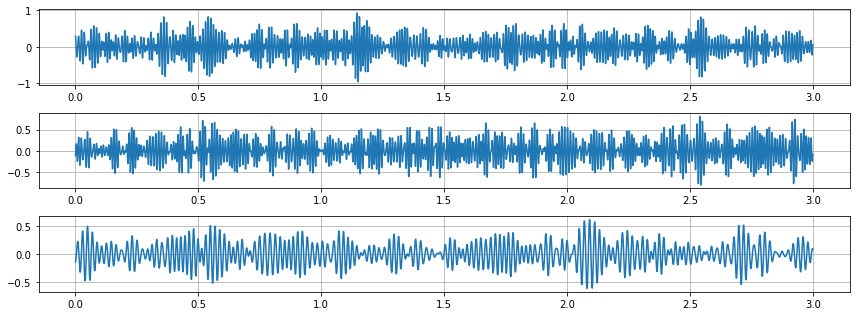

In [4]:
x_numpy = x.numpy()
y_numpy = y.detach().numpy()
scale = np.arange(x_numpy.shape[-1]) / srate

fig, ax = plt.subplots(n_channels, 1, figsize=(12, 1.5*n_channels))
for i in range(n_channels):
    
    ax[i].plot(scale, y_numpy[i,i])
    ax[i].set_xlabel('')
    ax[i].set_ylabel('')
    ax[i].set_title('')
    ax[i].grid(True)
    
plt.tight_layout()
plt.show()

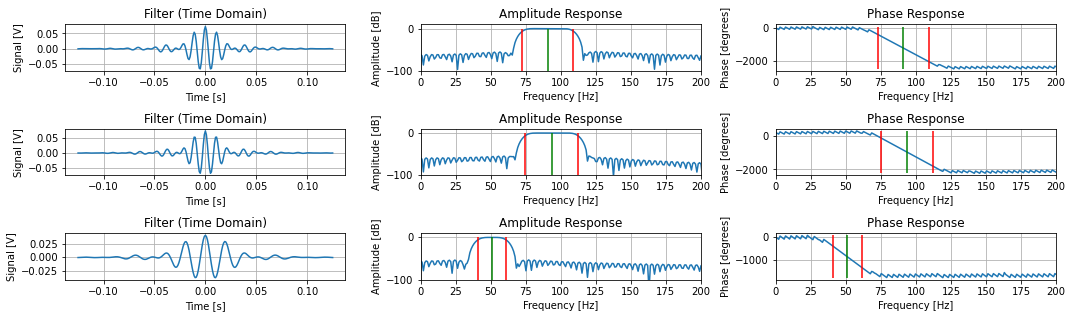

In [5]:
freqs, _, freq_low, freq_high = sinc._create_frequencies()
filt = sinc._create_filters(freq_low, freq_high).detach().numpy()
freqs, freq_low, freq_high = freqs.detach().numpy(), freq_low.detach().numpy(), freq_high.detach().numpy()
# filt = filter_hilbert.create_filters().detach().numpy()

fig, ax = plt.subplots(n_channels, 3, figsize=(15, 1.5*n_channels))
for i in range(n_channels):
    filter_coeffs = filt[i,0,0]
    w, h = sg.freqz(filter_coeffs, fs=srate * 2 * math.pi)
    freq = w / (2 * math.pi)
    amp = 20 * np.log10(np.abs(h))
    phase = np.unwrap(np.angle(h)) * 180 / math.pi
    
    
    ax[i,0].plot(sinc._scale.numpy(), filter_coeffs)
    ax[i,0].set_ylabel('Signal [V]')
    ax[i,0].set_xlabel('Time [s]')
    ax[i,0].set_title('Filter (Time Domain)')
    ax[i,0].grid(True)
    
    ax[i,1].plot(freq, amp)
    ax[i,1].vlines(freqs[i], np.min(amp), np.max(amp), colors='g')
    ax[i,1].vlines(freq_low[i], np.min(amp), np.max(amp), colors='r')
    ax[i,1].vlines(freq_high[i], np.min(amp), np.max(amp), colors='r')
    ax[i,1].set_ylim(-100, 10)
    ax[i,1].set_xlim(0, 200)
    ax[i,1].set_ylabel('Amplitude [dB]')
    ax[i,1].set_xlabel('Frequency [Hz]')
    ax[i,1].set_title('Amplitude Response')
    ax[i,1].grid(True)
    
    ax[i,2].plot(freq, phase)
    ax[i,2].vlines(freqs[i], np.min(phase), np.max(phase), colors='g')
    ax[i,2].vlines(freq_low[i], np.min(phase), np.max(phase), colors='r')
    ax[i,2].vlines(freq_high[i], np.min(phase), np.max(phase), colors='r')
    ax[i,2].set_xlim(0, 200)
    ax[i,2].set_xlabel('Frequency [Hz]')
    ax[i,2].set_ylabel('Phase [degrees]')
    ax[i,2].set_title('Phase Response')
    ax[i,2].grid(True)
    
plt.tight_layout()
plt.show()

# FilterHilbertLayer

In [6]:
sinc_hilbert = SincHilbertLayer2d(
    in_channels=in_channels,
    out_channels=out_channels,
    kernel_size=kernel_size,
    srate=srate,
    fmin_init=fmin_init,
    fmax_init=fmax_init,
    freq=frequency,
    bandwidth=bandwidth,
    seed=seed,
)

y_ = sinc_hilbert(x, return_filtered=True)
y = sinc_hilbert(x)

y_.mean().backward()
sinc_hilbert.coef_freq.grad

tensor([4.1061e-07, 1.4031e-06, 3.8979e-07, 1.1389e-06, 1.1495e-07, 1.4178e-06])

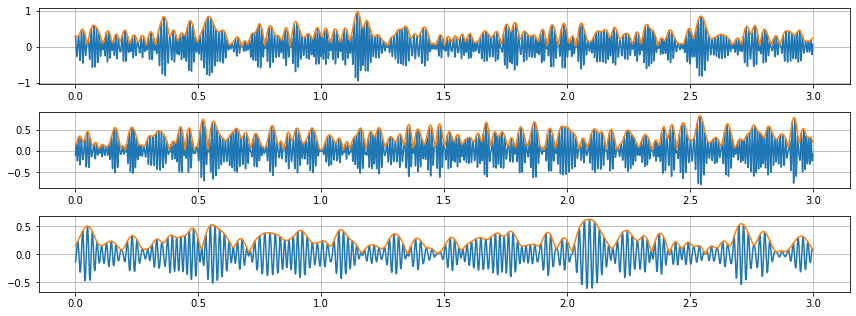

In [7]:
x_numpy = x.numpy()
y_numpy_ = y_.detach().numpy()
y_numpy = y.detach().numpy()
scale = np.arange(x_numpy.shape[-1]) / srate

fig, ax = plt.subplots(n_channels, 1, figsize=(12, 1.5*n_channels))
for i in range(n_channels):
    
    ax[i].plot(scale, y_numpy_[i,i])
    ax[i].plot(scale, y_numpy[i,i])
    ax[i].set_xlabel('')
    ax[i].set_ylabel('')
    ax[i].set_title('')
    ax[i].grid(True)
    
plt.tight_layout()
# plt.savefig('figure/sincnet_example')
plt.show()

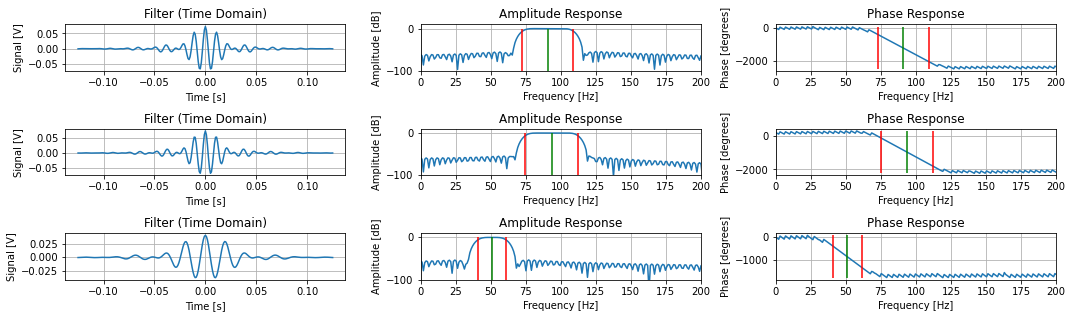

In [8]:
freqs, _, freq_low, freq_high = sinc_hilbert._create_frequencies()
filt = sinc_hilbert._create_filters(freq_low, freq_high).detach().numpy()
freqs, freq_low, freq_high = freqs.detach().numpy(), freq_low.detach().numpy(), freq_high.detach().numpy()
# filt = filter_hilbert.create_filters().detach().numpy()

fig, ax = plt.subplots(n_channels, 3, figsize=(15, 1.5*n_channels))
for i in range(n_channels):
    filter_coeffs = filt[i,0,0]
    w, h = sg.freqz(filter_coeffs, fs=srate * 2 * math.pi)
    freq = w / (2 * math.pi)
    amp = 20 * np.log10(np.abs(h))
    phase = np.unwrap(np.angle(h)) * 180 / math.pi
    
    
    ax[i,0].plot(sinc_hilbert._scale.numpy(), filter_coeffs)
    ax[i,0].set_ylabel('Signal [V]')
    ax[i,0].set_xlabel('Time [s]')
    ax[i,0].set_title('Filter (Time Domain)')
    ax[i,0].grid(True)
    
    ax[i,1].plot(freq, amp)
    ax[i,1].vlines(freqs[i], np.min(amp), np.max(amp), colors='g')
    ax[i,1].vlines(freq_low[i], np.min(amp), np.max(amp), colors='r')
    ax[i,1].vlines(freq_high[i], np.min(amp), np.max(amp), colors='r')
    ax[i,1].set_ylim(-100, 10)
    ax[i,1].set_xlim(0, 200)
    ax[i,1].set_ylabel('Amplitude [dB]')
    ax[i,1].set_xlabel('Frequency [Hz]')
    ax[i,1].set_title('Amplitude Response')
    ax[i,1].grid(True)
    
    ax[i,2].plot(freq, phase)
    ax[i,2].vlines(freqs[i], np.min(phase), np.max(phase), colors='g')
    ax[i,2].vlines(freq_low[i], np.min(phase), np.max(phase), colors='r')
    ax[i,2].vlines(freq_high[i], np.min(phase), np.max(phase), colors='r')
    ax[i,2].set_xlim(0, 200)
    ax[i,2].set_xlabel('Frequency [Hz]')
    ax[i,2].set_ylabel('Phase [degrees]')
    ax[i,2].set_title('Phase Response')
    ax[i,2].grid(True)
    
plt.tight_layout()
# plt.savefig('figure/sincnet_timefreq')
plt.show()

# WaveletLayer

In [9]:
wavelet = WaveletLayer2d(
    in_channels=in_channels,
    out_channels=out_channels,
    kernel_size=kernel_size,
    srate=srate,
    fmin_init=fmin_init,
    fmax_init=fmax_init,
    freq=frequency,
    bandwidth=bandwidth,
    seed=seed,
)

y = wavelet(x)

y.mean().backward()
wavelet.coef_freq.grad

tensor([ 4.0382e-08,  2.8030e-08, -1.0923e-07,  3.0663e-08, -2.7104e-07,
        -8.9982e-07])

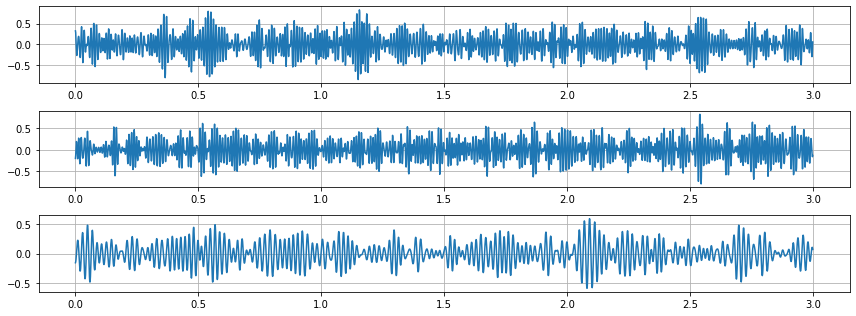

In [10]:
x_numpy = x.numpy()
y_numpy = y.detach().numpy()
scale = np.arange(x_numpy.shape[-1]) / srate

fig, ax = plt.subplots(n_channels, 1, figsize=(12, 1.5*n_channels))
for i in range(n_channels):
    
    ax[i].plot(scale, y_numpy[i,i])
    ax[i].set_xlabel('')
    ax[i].set_ylabel('')
    ax[i].set_title('')
    ax[i].grid(True)
    
plt.tight_layout()
plt.show()

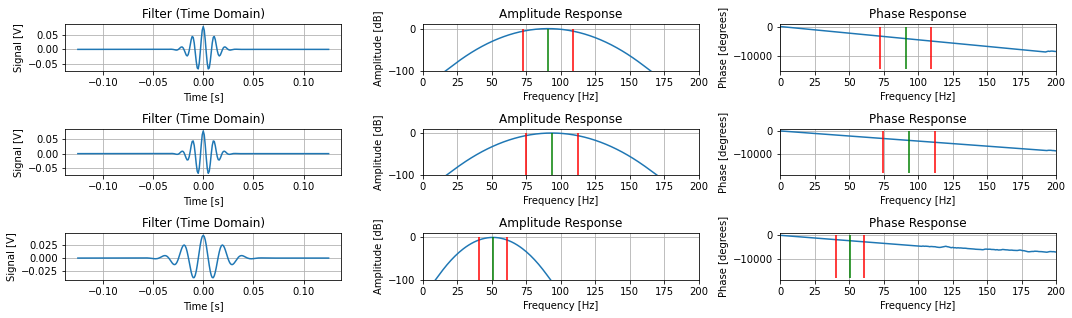

In [11]:
freqs, bw, freq_low, freq_high = wavelet._create_frequencies()
filt = wavelet._create_filters(freqs, bw).detach().numpy()
freqs, freq_low, freq_high = freqs.detach().numpy(), freq_low.detach().numpy(), freq_high.detach().numpy()

fig, ax = plt.subplots(n_channels, 3, figsize=(15, 1.5*n_channels))
for i in range(n_channels):
    filter_coeffs = filt[i,0,0]
    w, h = sg.freqz(filter_coeffs.real, fs=srate * 2 * math.pi)
    freq = w / (2 * math.pi)
    amp = 20*np.log10(np.abs(h) + 1e-6)
#     amp = np.abs(h)
    phase = np.unwrap(np.angle(h)) * 180 / math.pi
#     print(np.sum(amp > amp.max()/2) / freq[1] / freqs[0,0,0])
    
    ax[i,0].plot(wavelet._scale.numpy(), filter_coeffs)
    ax[i,0].set_ylabel('Signal [V]')
    ax[i,0].set_xlabel('Time [s]')
    ax[i,0].set_title('Filter (Time Domain)')
    ax[i,0].grid(True)
    
    ax[i,1].plot(freq, amp)
    ax[i,1].vlines(freqs[i], np.min(amp), np.max(amp), colors='g')
    ax[i,1].vlines(freq_low[i], np.min(amp), np.max(amp), colors='r')
    ax[i,1].vlines(freq_high[i], np.min(amp), np.max(amp), colors='r')
#     ax[i,1].set_ylim(0, 1)
    ax[i,1].set_ylim(-100, 10)
    ax[i,1].set_xlim(0, 200)
    ax[i,1].set_ylabel('Amplitude [dB]')
    ax[i,1].set_xlabel('Frequency [Hz]')
    ax[i,1].set_title('Amplitude Response')
    ax[i,1].grid(True)
    
    ax[i,2].plot(freq, phase)
    ax[i,2].vlines(freqs[i], np.min(phase), np.max(phase), colors='g')
    ax[i,2].vlines(freq_low[i], np.min(phase), np.max(phase), colors='r')
    ax[i,2].vlines(freq_high[i], np.min(phase), np.max(phase), colors='r')
    ax[i,2].set_xlim(0, 200)
    ax[i,2].set_xlabel('Frequency [Hz]')
    ax[i,2].set_ylabel('Phase [degrees]')
    ax[i,2].set_title('Phase Response')
    ax[i,2].grid(True)
    
plt.tight_layout()
plt.show()

# ComplexWaveletLayer

In [12]:
complex_wavelet = ComplexWaveletLayer2d(
    in_channels=in_channels,
    out_channels=out_channels,
    kernel_size=kernel_size,
    srate=srate,
    fmin_init=fmin_init,
    fmax_init=fmax_init,
    freq=frequency,
    bandwidth=bandwidth,
    seed=seed,
)

y_ = complex_wavelet(x, return_filtered=True)
y = complex_wavelet(x)

y.mean().backward()
complex_wavelet.coef_freq.grad

tensor([0.0003, 0.0002, 0.0004, 0.0002, 0.0003, 0.0003])

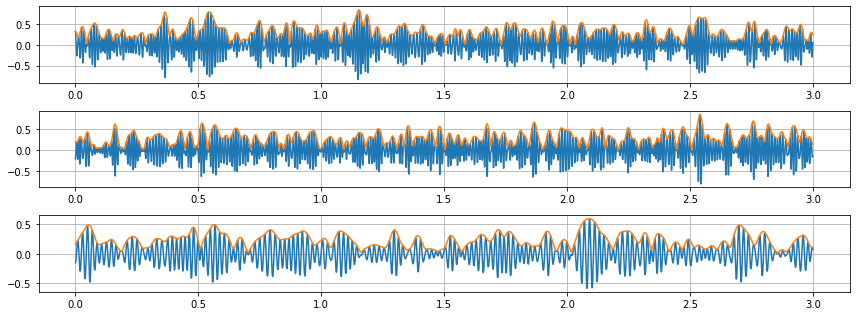

In [13]:
x_numpy = x.numpy()
y_numpy_ = y_.detach().numpy()
y_numpy = y.detach().numpy()
scale = np.arange(x_numpy.shape[-1]) / srate

fig, ax = plt.subplots(n_channels, 1, figsize=(12, 1.5*n_channels))
for i in range(n_channels):
    
    ax[i].plot(scale, y_numpy_[i,i])
    ax[i].plot(scale, y_numpy[i,i])
    ax[i].set_xlabel('')
    ax[i].set_ylabel('')
    ax[i].set_title('')
    ax[i].grid(True)
    
plt.tight_layout()
# plt.savefig('figure/wavelets_example')
plt.show()

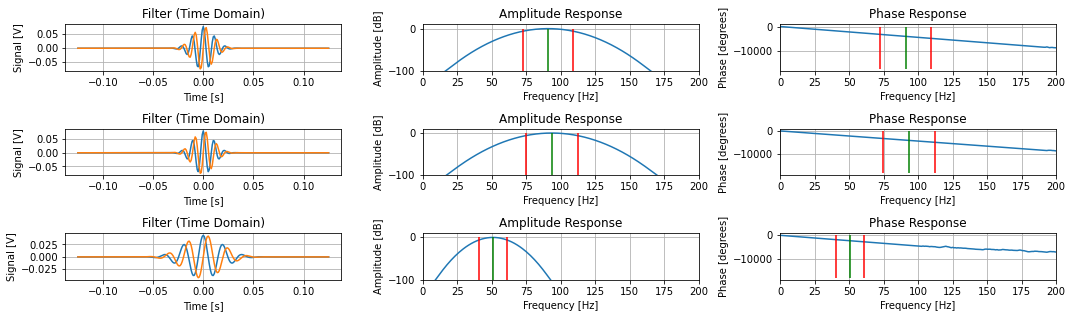

In [14]:
freqs, bw, freq_low, freq_high = complex_wavelet._create_frequencies()
filt = complex_wavelet._create_filters(freqs, bw).detach().numpy()
freqs, freq_low, freq_high = freqs.detach().numpy(), freq_low.detach().numpy(), freq_high.detach().numpy()

fig, ax = plt.subplots(n_channels, 3, figsize=(15, 1.5*n_channels))
for i in range(n_channels):
    filter_coeffs = filt[i,0,0]
    w, h = sg.freqz(filter_coeffs.real, fs=srate * 2 * math.pi)
    freq = w / (2 * math.pi)
    amp = 20*np.log10(np.abs(h) + 1e-6)
#     amp = np.abs(h)
    phase = np.unwrap(np.angle(h)) * 180 / math.pi
#     print(np.sum(amp > amp.max()/2) / freq[1] / freqs[0,0,0])
    
    ax[i,0].plot(complex_wavelet._scale.numpy(), filter_coeffs.real)
    ax[i,0].plot(complex_wavelet._scale.numpy(), filter_coeffs.imag)
    ax[i,0].set_ylabel('Signal [V]')
    ax[i,0].set_xlabel('Time [s]')
    ax[i,0].set_title('Filter (Time Domain)')
    ax[i,0].grid(True)
    
    ax[i,1].plot(freq, amp)
    ax[i,1].vlines(freqs[i], np.min(amp), np.max(amp), colors='g')
    ax[i,1].vlines(freq_low[i], np.min(amp), np.max(amp), colors='r')
    ax[i,1].vlines(freq_high[i], np.min(amp), np.max(amp), colors='r')
#     ax[i,1].set_ylim(0, 1)
    ax[i,1].set_ylim(-100, 10)
    ax[i,1].set_xlim(0, 200)
    ax[i,1].set_ylabel('Amplitude [dB]')
    ax[i,1].set_xlabel('Frequency [Hz]')
    ax[i,1].set_title('Amplitude Response')
    ax[i,1].grid(True)
    
    ax[i,2].plot(freq, phase)
    ax[i,2].vlines(freqs[i], np.min(phase), np.max(phase), colors='g')
    ax[i,2].vlines(freq_low[i], np.min(phase), np.max(phase), colors='r')
    ax[i,2].vlines(freq_high[i], np.min(phase), np.max(phase), colors='r')
    ax[i,2].set_xlim(0, 200)
    ax[i,2].set_xlabel('Frequency [Hz]')
    ax[i,2].set_ylabel('Phase [degrees]')
    ax[i,2].set_title('Phase Response')
    ax[i,2].grid(True)
    
plt.tight_layout()
# plt.savefig('figure/wavelets_timefreq')
plt.show()